**Name:** JENNIFER AGU <br>
**Student_ID:** 8882641

# Introduction

## Framing the Problem
This project's objective is to develop and evaluate a deep learning model for image classification into distinct categories. The model is trained using dataset with a collection of labeled images that must be processed before being fed into a neural network. Our goal is to investigate different methods to maximize the model's performance, such as training a custom CNN from scratch and transfer learning (using a pre-trained VGG16 model).  We may evaluate the benefits of transfer learning over creating a model from scratch, especially for image classification tasks, by comparing the performance of these two models.

## Import the required python Libraries

In [67]:
import os, shutil, pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter


# 1. Obtain the Data: Get the Dogs vs Cats dataset

In [68]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

# Load the train dataset fron the data_folder/train folder path, resize the image to a 180 x 180 pixels and then group them in a batch size of 32
train_dataset = image_dataset_from_directory(data_folder / "train", image_size=(180, 180), batch_size=32)

# Load the validation dataset fron the data_folder/validation folder path, resize the image to a 180 x 180 pixels and then group them in a batch size of 32
validation_dataset = image_dataset_from_directory( data_folder / "validation", image_size=(180, 180), batch_size=32)

# Load the test dataset fron the data_folder/test folder path, resize the image to a 180 x 180 pixels and then group them in a batch size of 32
test_dataset = image_dataset_from_directory(data_folder / "test",image_size=(180, 180),batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# 2. EDA: Explore the data with relevant graphs, statistics and insights

- Explore the data and label batch shape for the train, test and validation dataset.

In [69]:
print('Train Data:')
for data_batch, labels_batch in train_dataset:
    print("data batch shape for the train data:", data_batch.shape)
    print("labels batch shape for the train data:", labels_batch.shape)
    break

print('\nValidation Data:')
for data_batch, labels_batch in validation_dataset:
    print("data batch shape for the Validation Data :", data_batch.shape)
    print("labels batch shape for the Validation Data:", labels_batch.shape)
    break 

print('\nTest Data:')
for data_batch, labels_batch in test_dataset:
    print("data batch shape for the test Data:", data_batch.shape)
    print("labels batch shape for the test Data:", labels_batch.shape)
    break


Train Data:
data batch shape for the train data: (32, 180, 180, 3)
labels batch shape for the train data: (32,)

Validation Data:
data batch shape for the Validation Data : (32, 180, 180, 3)
labels batch shape for the Validation Data: (32,)

Test Data:
data batch shape for the test Data: (32, 180, 180, 3)
labels batch shape for the test Data: (32,)


**Explain:**
This shows that the train, validation and test dataset have a data batch size of (32, 180, 180, 3) which means the each batch have 32 images, 180 by 180 pixels size and the 3 which is the number of channels that is the image color are Red, Green, and Blue (RGB). Also the labels shape of 32 indicates one for each of the image in the batch which are 0 and 1 depending on whether its cat or dog.

- Explore the images in the train dataset

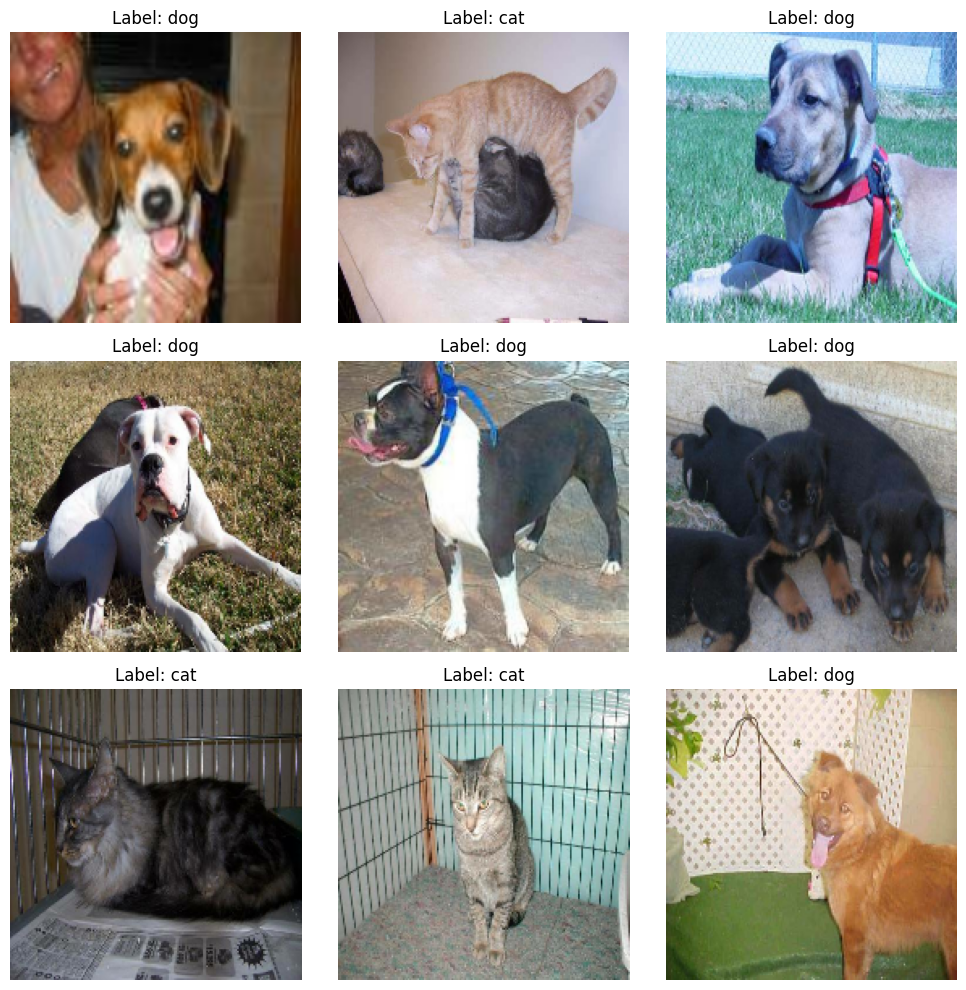

In [70]:
# Define a function to plot different sample images from the data set
def plot_sample_images(dataset, class_names):
    plt.figure(figsize=(10, 10))

    # Consider a single batch from the dataset
    for images, labels in dataset.take(1): 
        # Loop through the first 9 images in the batch
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))                   # Display the image after converting it to the right format
            plt.title(f"Label: {class_names[int(labels[i])]}")              # Set the the title of the plot using the class name
            plt.axis("off")                                                 # Hide the axis
    plt.tight_layout()
    plt.show()                                                              # Display the plot

class_names = train_dataset.class_names                                     # Get the class names from the train dataset
plot_sample_images(train_dataset, class_names)                              # Call the function to plot the sample images from the train dataset

**Explain:**
As we can see, there is variation in pose, background, lighting, and image quality among the images, which are of various orientations and belong to both classes (dogs and cats).  This variation helps in improving the model's ability to generalize across real-world situations.

- Explore the distribution of classes (cats and dogs) in the training dataset

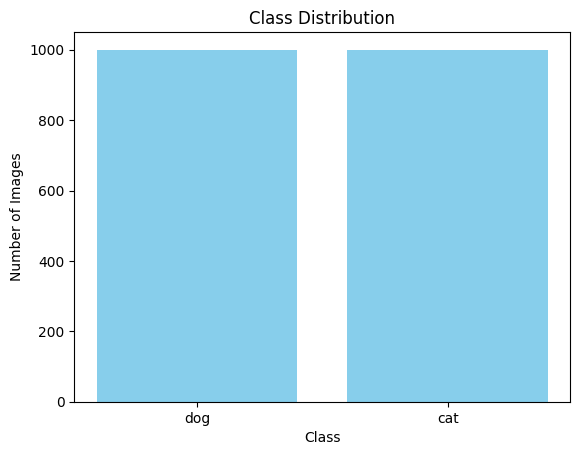

Label counts: {'dog': 1000, 'cat': 1000}


In [71]:
# Define a function to count the number of samples in each of the classes
def get_label_distribution(dataset):
    label_counts = Counter()
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        label_counts[label] += 1
    return label_counts

# Apply the function on the train dataset
label_dist = get_label_distribution(train_dataset)

# Map the label indices to their labels
label_names = [class_names[k] for k in label_dist.keys()]
label_values = list(label_dist.values())

# Plot the bar chart
plt.bar(label_names, label_values, color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Display the counts of each labels
print(f"Label counts: {dict(zip(label_names, label_values))}")


**Explain:**
We can see from this bar chart that the training dataset is balanced between the classes(cats and dogs) which is ideal for training a model because it will reduce the risk of the model being biased.

# 3. Train two networks

## 3.1 Define a Neural Network of your choice

### Defining the model

Convolutional Neural Network(CNN) are a subset of deep learning models created especially to process image data. Tasks like object identification, face recognition, image classification, and more are frequently performed with it. Here we will be using it for classification of cats and dogs.

The model takes an input of 180 by 180 pixel images with 3 channels (RGB) and consists of:
- 5 Convolutional layers with the filter size increasing from 32 to 256 to extract features from the images.
- 4 MaxPooling layers  with a pool_size of 2 which is after most convolutional layer. it is used to reduce the spatial dimensions (height and width) and the computation to help the model focus the the features that are importance.
- Flatten layer does the work of converting the 2D feature to a 1D vector to prepare the data for the classification layer.
- The Dense output layer has a single neuron using sigmoid for the activation

In [72]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
cnn_model = keras.Model(inputs=inputs, outputs=outputs)

In [73]:
cnn_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

**Summary**
From this we could see that the total number of parameters is 991,041 and the trainable parameters is also 991,041.

We will be compling the CNN model using the binary crossentropy loss, RMSprop optimizer and we will use the accuracy as the evaluation metrics. We will also be using a callback to save the best model based the the validation loss. Then we will be training the model for 30 epochs using the train and validation dataset. <br>
We will save the best-performing version in ./models/cnn_from_scratch.keras path. Store the training history to visualize or analyze later

In [ ]:
# Compile the CNN model
cnn_model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Define callbacks to enhance the training of the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/cnn_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train the CNN Model
history = cnn_model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 69s 1s/step - loss: 0.7048 - accuracy: 0.5255 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 62s 987ms/step - loss: 0.6968 - accuracy: 0.5280 - val_loss: 0.6868 - val_accuracy: 0.5070
Epoch 3/30
63/63 [==============================] - 59s 928ms/step - loss: 0.6901 - accuracy: 0.5655 - val_loss: 0.6700 - val_accuracy: 0.6040
Epoch 4/30
63/63 [==============================] - 57s 909ms/step - loss: 0.6561 - accuracy: 0.6275 - val_loss: 0.6727 - val_accuracy: 0.5860
Epoch 5/30
63/63 [==============================] - 59s 929ms/step - loss: 0.6399 - accuracy: 0.6395 - val_loss: 0.6365 - val_accuracy: 0.6340
Epoch 6/30
63/63 [==============================] - 59s 935ms/step - loss: 0.5953 - accuracy: 0.6855 - val_loss: 0.5945 - val_accuracy: 0.6680
Epoch 7/30
63/63 [==============================] - 75s 1s/step - loss: 0.5619 - accuracy: 0.7095 - val_loss: 0.6778 - val_accuracy: 0.6510
Epoch

**Explain** <br>
Observing the result:<br>
The training accuracy rate starts with 0.5255(approximately 53%) then increases to 0.9930 during epoch 30.<br>
The validation accuracy was maximum at epoch 13 with a value of 0.7380.<br>
The training loss decreases with time throughout.<br>
The validation loss was lowest at epoch 8 with the value 0.5754.

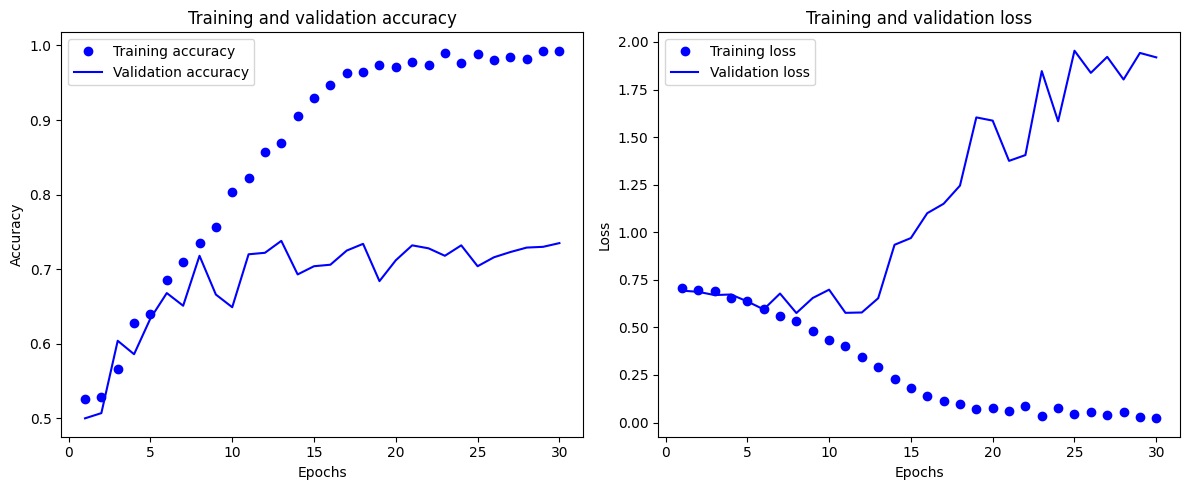

In [75]:
# Extract the metrics from the history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# figure size for the subplots
plt.figure(figsize=(12, 5))

# Plot the Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

**Explain:**
Observing this visualize graph we could see that overfitting is evident, around epoch 8 where the validation loss is the lowest. 

## 3.2 Fine-Tune VGG16 (pre-trained on imagenet)

- We will be loading the pretrained VGG16 model with ImageNet weights and exclude the top layers to be able to use the convolutional base as a feature extractor the the dataset

In [76]:
# Load the VGG16 model without the top layer and with pretrained ImageNet weights
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False
)

# Print model summary
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Summary:**
From this we could see that the total number of parameters is 14,714,688 and the trainable parameters is also 14,714,688.

**Explain:**
We will be retrieving data features and labels from a dataset through application of the pretrained VGG16 model. We will apply VGG16-specific preprocessing to image batches afterward images move through the convolutional base for feature representation before saving corresponding labels. The function will be applied to each of the training, validation and test datasets to retrieve extracted features and labels.

In [77]:
# Define a function to extract features and labels from the dataset using the VGG16 convolutional base
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []

    # Loop through each batch of the images and labels in the dataset
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract features and labels for train, validation and test datasets
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 2s 2s/step


**Defining the densely connected classifier**

**Summary:**
The weights of the pretrained VGG16 convolutional base will be frozen during training preventing them from updating. After that we will develop a custom classification model on top of it. The model uses a flattening layer followed by a dense hidden layer with ReLU activation and then adds a dropout layer for overfitting prevention and concludes with a sigmoid output layer for binary classification.

In [78]:
# Freeze the convolutional base
conv_base.trainable = False

# Build the model on top of the conv base
inputs = keras.Input(shape=(180, 180, 3))
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

vgg_model = keras.Model(inputs, outputs)

# Print model summary
vgg_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 17,992,001
Trainable params: 3,277,313
Non-tr

**Explain:**
The model has a total of 17,992,001 parameters, out of which are 3,277,313 trainable parameters from the newly added layers with 14,714,688 non-trainable parameters from the frozen VGG16 base.

In [ ]:
# Compile the VGG16 model
vgg_model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Define callbacks to enhance the training of the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/vgg16_model.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train the VGG16 Model
history = vgg_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 438s 7s/step - loss: 7.9452 - accuracy: 0.8870 - val_loss: 1.3846 - val_accuracy: 0.9400
Epoch 2/50
63/63 [==============================] - 357s 6s/step - loss: 1.4545 - accuracy: 0.9475 - val_loss: 1.9854 - val_accuracy: 0.9030
Epoch 3/50
63/63 [==============================] - 382s 6s/step - loss: 0.5191 - accuracy: 0.9645 - val_loss: 0.6793 - val_accuracy: 0.9470
Epoch 4/50
63/63 [==============================] - 400s 6s/step - loss: 0.2682 - accuracy: 0.9815 - val_loss: 1.0961 - val_accuracy: 0.9340
Epoch 5/50
63/63 [==============================] - 370s 6s/step - loss: 0.2148 - accuracy: 0.9855 - val_loss: 0.7397 - val_accuracy: 0.9490
Epoch 6/50
63/63 [==============================] - 343s 5s/step - loss: 0.1540 - accuracy: 0.9845 - val_loss: 0.7253 - val_accuracy: 0.9580
Epoch 7/50
63/63 [==============================] - 402s 6s/step - loss: 0.1767 - accuracy: 0.9895 - val_loss: 0.8830 - val_accuracy: 0.9540
Epoch 8/50
63

**Explain:**<br>
Observing the result:<br>
The training accuracy rate starts with 0.8870(approximately 89%) then increases to 0.9995(approximately 100%) during epoch 50 which suggest that the model was getting better in classifying the training dataset. Also noticed that at epoch 39 the training accuracy was 100%.<br>
The validation accuracy was maximum at epoch 35 with a value of 0.9640 which suggest that the model performs very well in classifying the validation dataset.<br>
The training loss was fluctuating that is increasing and decreasing with time throughout.<br>
The validation loss was lowest at epoch 3 with the value 0.6793 which means the model is overfitting at this point.

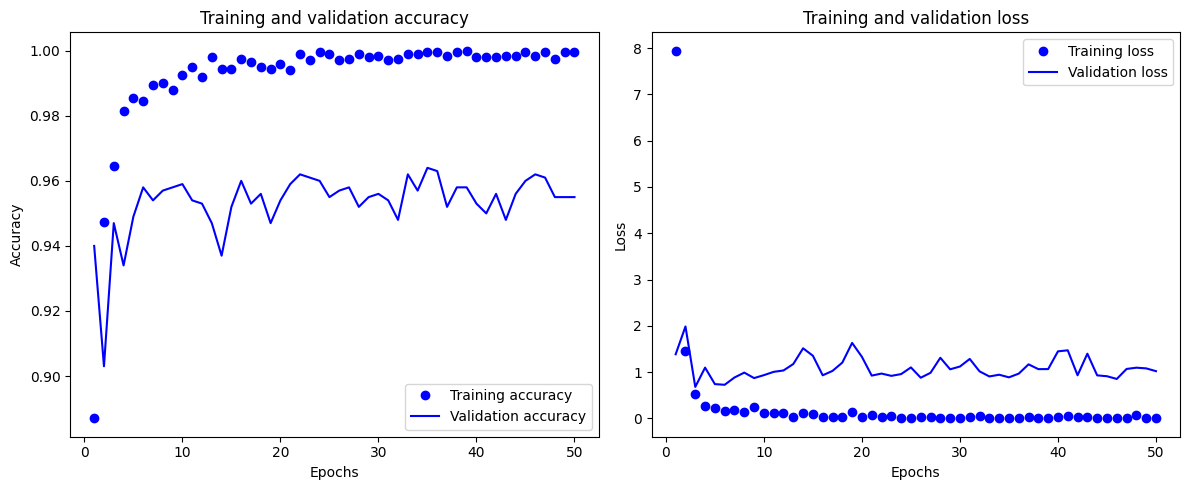

In [80]:
# Extract the metrics from the history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# figure size for the subplots
plt.figure(figsize=(12, 5))

# Plot the Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

**Explain**
Observing this visualize graph we could see around epoch 3 was where the validation loss is the lowest. 

# 4. Explore the relative performance of the models

In [81]:
# Convert test dataset to NumPy arrays
test_images_list = []
test_labels_list = []

for images, labels in test_dataset:  
    test_images_list.append(images.numpy())
    test_labels_list.append(labels.numpy())

test_images = np.concatenate(test_images_list)
test_labels = np.concatenate(test_labels_list)

## 4.1 Accuracy

**Accuracy for the CNN Model**

In [82]:
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)

# Print the Accuracy for the CNN Model
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 21s 303ms/step - loss: 0.5636 - accuracy: 0.7220
Test accuracy: 0.722


**Accuracy for the VGG16 Model**

In [83]:
test_model = keras.models.load_model( "./models/vgg16_model.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)

# Print the Accuracy for the VGG16 Model
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 196s 3s/step - loss: 0.6315 - accuracy: 0.9595
Test accuracy: 0.960


**Conclusion:**
The VGG16 model with a test accuracy of 96.0% perform better compared to the CNN Model with a test accuracy of 72.2%

## 4.2 Confusion metric

**Confusion metric for the CNN Model**

63/63 [==============================] - 17s 258ms/step


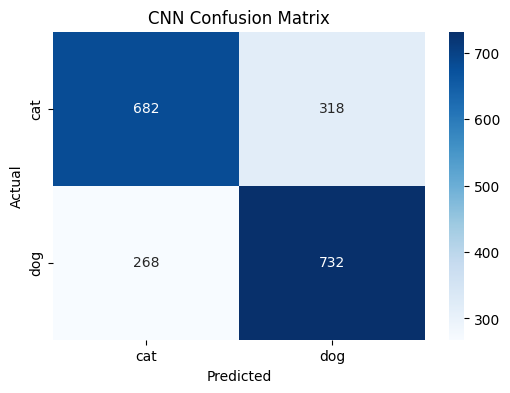

In [84]:
# Load the saved models 
cnn_model = load_model('./models/cnn_from_scratch.keras')

# Make predictions 
cnn_predictions = cnn_model.predict(test_images)
cnn_predictions = (cnn_predictions > 0.5).astype("int32").flatten()

# Plot the confusion matrix
cnn_cm = confusion_matrix(test_labels, cnn_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Confusion metric for the VGG16 Model**

63/63 [==============================] - 233s 4s/step


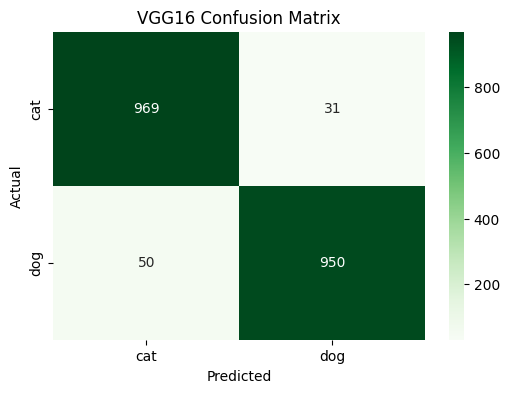

In [85]:
# Load the saved model (VGG16 with feature extraction) ---
vgg_model = load_model('./models/vgg16_model.keras')

# Get predictions from the model 
vgg_predictions = vgg_model.predict(test_images)
vgg_predictions = (vgg_predictions > 0.5).astype("int32").flatten()

# Confusion Matrix 
vgg_cm = confusion_matrix(test_labels, vgg_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(vgg_cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Conclusion:**
From the confusion matrix of the CNN Model, we could see that the model misclassified 318 cats as dogs and 268 dogs as cats while the confusion Matrix of the VGG16 Model shows that the model misclassified 31 cats as dogs and 50 dogs are cats. From these result we could say that the VGG16 Model did better in classifying the dogs and cats compared to the CNN Model.

## 4.3 Precision, Recall and F1-score

**Precision, Recall and F1-score for the CNN Model**

In [86]:
# CNN Evaluation
print("CNN Classification Report:")
print(classification_report(test_labels, cnn_predictions, target_names=class_names))

CNN Classification Report:
              precision    recall  f1-score   support

         cat       0.72      0.68      0.70      1000
         dog       0.70      0.73      0.71      1000

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000



**Precision, Recall and F1-score for the VGG16 Model**

In [87]:
print("VGG16 Classification Report:")
print(classification_report(test_labels, vgg_predictions, target_names=class_names))

VGG16 Classification Report:
              precision    recall  f1-score   support

         cat       0.95      0.97      0.96      1000
         dog       0.97      0.95      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



**Conclusion**<br>
For Cats:
* Precision: from the classification report the precision for the CNN Model was 72% and for the VGG16 Model was 95% which suggests that the VGG16 Model has better abilty compare to the CNN Model to identify cats. 
* Recall: from the classification report the recall for the CNN Model was 68% and for the VGG16 Model was 97% which suggests that the VGG16 Model is a better model compared to the CNN Model in classifying actuall cats. 
* F1-Score: from the classification report the f1-score for the CNN Model was 70% and for the VGG16 Model was 96% which suggests that the VGG16 Model has more balance between the recall and the precision compared to the CNN Model leading the better performance overall.

For Dogs:
* Precision: from the classification report the precision for the CNN Model was 70% and for the VGG16 Model was 97% which suggests that the VGG16 Model has has better abilty compare to the CNN Model to identify dogs. 
* Recall: from the classification report the recall for the CNN Model was 73% and for the VGG16 Model was 95% which suggests that the VGG16 Model has a better model compared to the CNN Model in classifying actuall dogs. 
* F1-Score: from the classification report the f1-score for the CNN Model was 71% and for the VGG16 Model was 96% which suggests that the VGG16 Model has more balance between the recall and the precision compared to the CNN Model leading the better performance overall.

In conclusion, from the classification report we could say that the VGG16 Model performs better compare to the CNN Model in the classification of cats and dogs.

63/63 [==============================] - 273s 4s/step


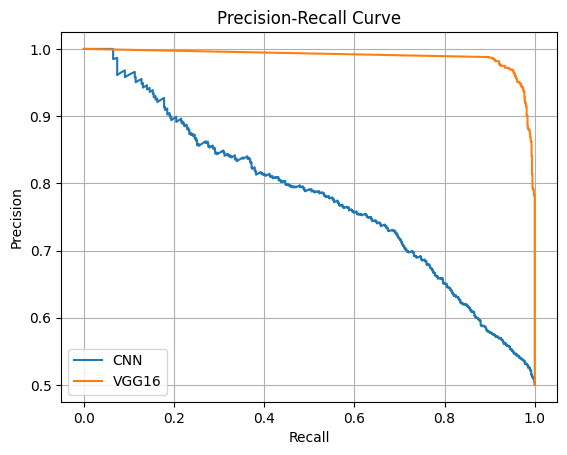

In [88]:
# Precision-Recall Curve for CNN Model
cnn_probabilities = cnn_model.predict(test_images).flatten()
precision_cnn, recall_cnn, _ = precision_recall_curve(test_labels, cnn_probabilities)
plt.plot(recall_cnn, precision_cnn, label="CNN")

# Precision-Recall Curve for VGG16 Model
vgg_probabilities = vgg_model.predict(test_images).flatten()
precision_vgg, recall_vgg, _ = precision_recall_curve(test_labels, vgg_probabilities)
plt.plot(recall_vgg, precision_vgg, label="VGG16")

# Plot 
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

**Conclusion:**
* The VGG16 model maintains high precision levels throughout all recall levels which demonstrates its capability to detect positives with minimal errors. The model achieves 1.0 recall fast because it has a strong capability to detect correct positive instances.
* The CNN model displays a fast decrease in precision while recall levels increases which demonstrates its poor ability in reducing false positive errors when predicting positive cases.
* In conclusion, the CNN model struggles to achieve high accuracy as recall increases, but the VGG16 model does a far better job of striking a balance between precision and recall.

## 4.5 Explore specific examples in which the model failed to predict correctly

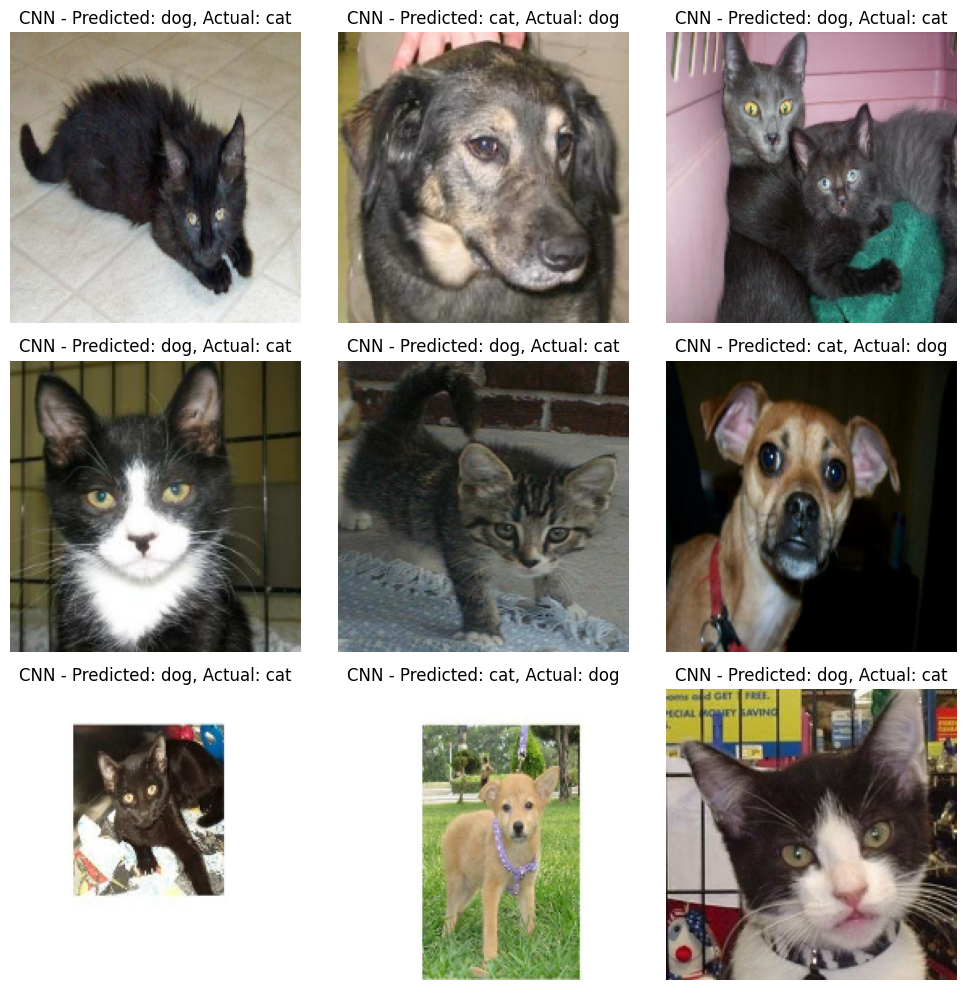

In [89]:
# Show wrong predictions from CNN 
cnn_wrong_indices = np.where(cnn_predictions != test_labels)[0]

# Set up a 3x3 grid to display images
plt.figure(figsize=(10, 10))

# Display the some examples where the CNN model made wrong predictions:
for i in range(9):
    idx = cnn_wrong_indices[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[idx].astype("uint8"))
    plt.title(f"CNN - Predicted: {class_names[cnn_predictions[idx]]}, Actual: {class_names[test_labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


**Conculsion:**
Looking at these images the CNN Model should have classified them better because the cats and dogs in these images have distinct feature that could help classify them correctly.

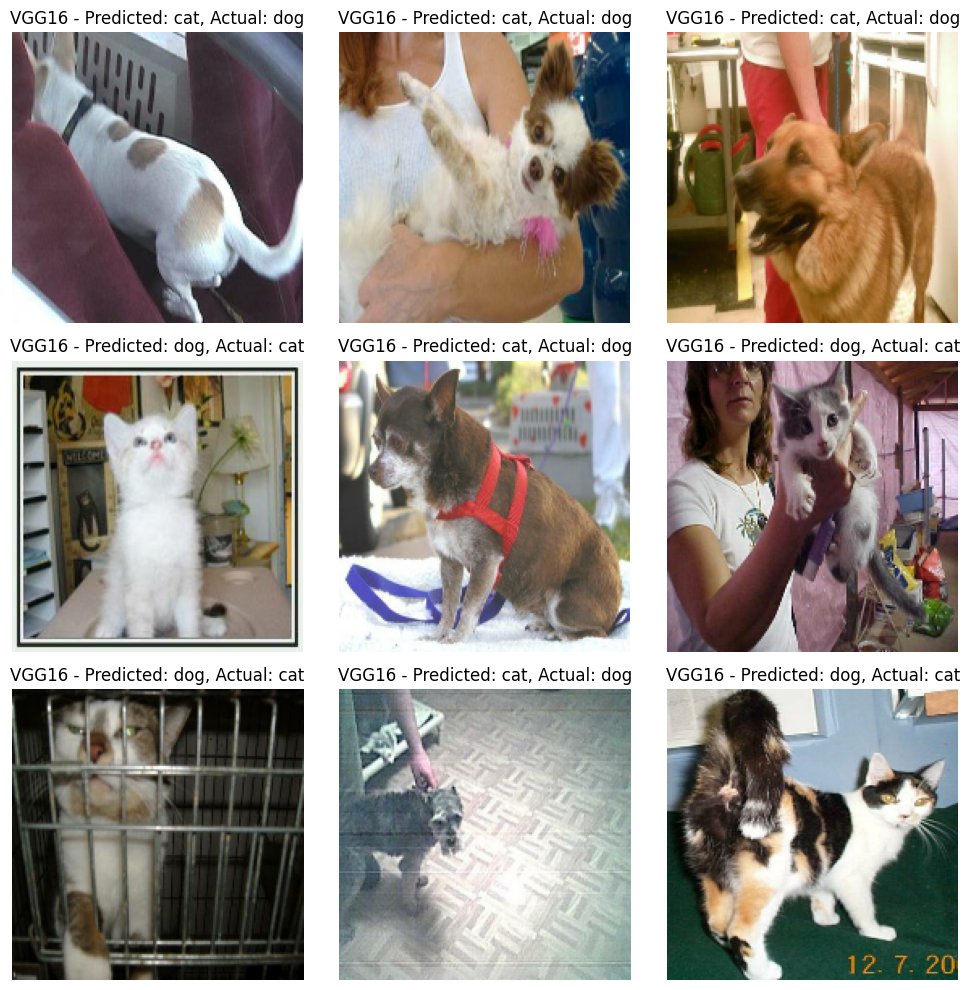

In [90]:
# Display where the model made a wrong predictions from VGG16 
vgg_wrong_indices = np.where(vgg_predictions != test_labels)[0]

# Set up a 3x3 grid to display images
plt.figure(figsize=(10, 10))

# Display the some examples where the CNN model made wrong predictions:
for i in range(9):
    idx = vgg_wrong_indices[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[idx].astype("uint8"))
    plt.title(f"VGG16 - Predicted: {class_names[vgg_predictions[idx]]}, Actual: {class_names[test_labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


**Conclusion:**
Looking at these images could say that the VGG16 model incorrectly identified these images due to low image quality, unclear stances, comparable appearances between cats and dogs, and deceptive contextual elements like background or animals being held together.

## Final Conclusion

In conclusion, The VGG16 pre-trained model and the CNN model were both successful in image classification; however, the VGG16 model, which used transfer learning, generally produced better results in terms of accuracy and generalization, while the CNN model, although capable of performing well, needs more computational resources and a larger amount of training data to match the performance of the transfer learning approach. This implies that, for similar image classification tasks, using pre-trained models can greatly cut down on training time and enhance model performance, particularly when the dataset is limited.